In [10]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, optimizers


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

from pathlib import Path
import math

from google.colab import drive
from google.colab import files


In [8]:
!nvidia-smi

Fri Dec 12 03:03:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaelrlooney/electricity-load-diagrams-2011-2014")

print("Path to dataset files:", path)

100%|██████████| 251M/251M [00:01<00:00, 156MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/michaelrlooney/electricity-load-diagrams-2011-2014/versions/1


In [18]:
!ls /root/.cache/kagglehub/datasets/michaelrlooney/electricity-load-diagrams-2011-2014/versions/1

LD2011_2014.txt


# Datos (15 min)

In [19]:
df_15min = pd.read_csv('/root/.cache/kagglehub/datasets/michaelrlooney/electricity-load-diagrams-2011-2014/versions/1/LD2011_2014.txt',
                       sep = ';', parse_dates = [0], index_col=0, decimal=',', dtype=np.float64 
                    )

df_15min.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_15min.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


In [21]:
df_15min.shape

(140256, 370)

# Pre-procesamiento

In [22]:
df_15min = df_15min.sort_index()
df_15min = df_15min[~df_15min.index.duplicated(keep="first")]

In [23]:
expected_freq = pd.infer_freq(df_15min.index[:8]) or "15T"
print("Inferred 15-min frequency (approx):", expected_freq)

Inferred 15-min frequency (approx): 15min


In [24]:
full_idx = pd.date_range(df_15min.index.min(), df_15min.index.max(), freq="15T")
if len(full_idx) != len(df_15min.index):
    print("Reindexing to full 15-min grid and forward-filling missing values...")
    df_15min = df_15min.reindex(full_idx).ffill()

/tmp/ipython-input-507045246.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(df_15min.index.min(), df_15min.index.max(), freq="15T")


In [25]:
df_daily = df_15min.resample("1D").sum()

print("Daily shape:", df_daily.shape)
df_daily.head(3)

Daily shape: (1462, 370)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_daily

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2011-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2011-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2011-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2011-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,227.157360,2131.578947,151.172893,14327.235772,6776.829268,20122.023810,429.621255,25255.892256,5118.881119,4794.623656,...,28815.132049,3272100.0,220721.518987,257477.272727,8169.491525,552.369807,45914.837577,4405.676127,66135.630499,1.553189e+06
2014-12-29,248.730964,2212.660028,160.729800,14067.073171,7198.780488,22824.404762,550.593556,30286.195286,6697.552448,6337.634409,...,28825.124911,3109100.0,206852.320675,269090.909091,8438.070404,1153.891164,53928.884987,12914.858097,73882.697947,1.806486e+06
2014-12-30,232.233503,2205.547653,165.073849,14290.650407,7189.024390,23880.952381,586.772188,30909.090909,6487.762238,6489.247312,...,28488.222698,2904300.0,204126.582278,263613.636364,10615.384615,892.334699,56334.503951,15996.661102,73950.146628,1.867568e+06
2014-12-31,229.695431,2273.115220,166.811468,14006.097561,7023.170732,23511.904762,690.785755,28700.336700,6211.538462,5034.408602,...,26970.735189,2748800.0,162556.962025,215886.363636,7415.906128,530.134582,50259.877085,13245.409015,70416.422287,1.365892e+06


In [27]:
W = 15   # lookback window
H = 7    # forecast horizon

def make_windows(arr, window=W, horizon=H):
    X, y = [], []
    for i in range(len(arr) - window - horizon + 1):
        X.append(arr[i:i+window])
        y.append(arr[i+window:i+window+horizon].ravel())
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

In [28]:
X = np.empty(shape=(0,W))
y = np.empty(shape=(0,H))

n_cols = len(df_daily.columns)

for i in range(n_cols):
    arr = df_daily.iloc[:,i].values
    X_, y_ = make_windows(arr, W, H)
    X = np.concatenate([X, X_], axis=0)
    y = np.concatenate([y, y_], axis=0)

In [29]:
X.shape

(533170, 15)

In [30]:
y.shape

(533170, 7)

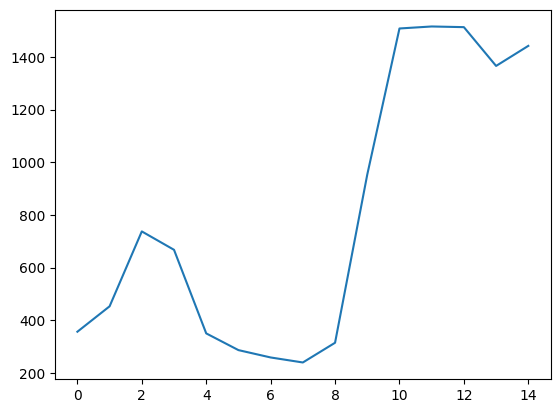

In [31]:
series = X[400]
plt.plot(series)
plt.show()

In [32]:
permutation = np.random.permutation(len(X))

X = X[permutation]
y = y[permutation]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled.shape

(319902, 15)

In [36]:
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train)
y_val_scaled = scaler2.transform(y_val)
y_test_scaled = scaler2.transform(y_test)

## Para una celda LSTM

**Forget gate**

$
F_t = \sigma(W_f x_t + U_f H_{t-1} + b_f)
$

**Input gate**

$
I_t = \sigma(W_i x_t + U_i H_{t-1} + b_i)
$

**Candidate cell state**

$
\tilde{C}_t = \tanh(W_c x_t + U_c H_{t-1} + b_c)
$

**New cell state**

$
C_t = f_t \odot C_{t-1} + I_t \odot \tilde{C}_t
$

**Output gate**

$
O_t = \sigma(W_o x_t + U_o H_{t-1} + b_o)
$

**New hidden state**

$
H_t = O_t \odot \tanh(C_t)
$

Entonces la función de transición nos queda:

$
f_{\theta}(x_t, H_{t-1}, C_{t-1}) = (h_t, c_t)
$



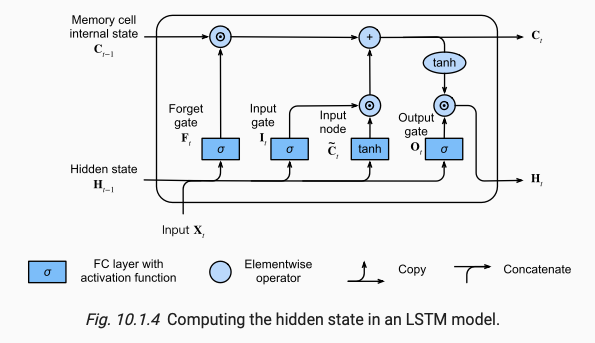

[Referencia](https://d2l.ai/chapter_recurrent-modern/lstm.html)

In [37]:
def build_model(window=W, horizon=H):
    inputs = tf.keras.Input(shape=(window, 1))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(horizon)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,423 (454.78 KB)

 Trainable params: 116,423 (454.78 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
ckpt_dir = Path("checkpoints"); ckpt_dir.mkdir(exist_ok=True)
ckpt_path = str(ckpt_dir / "best.keras")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss")
]

In [39]:
ckpt_path

'checkpoints/best.keras'

In [40]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.2517 - mae: 0.0579 - val_loss: 0.0376 - val_mae: 0.0169
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0360 - mae: 0.0377 - val_loss: 0.0193 - val_mae: 0.0145
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0306 - mae: 0.0373 - val_loss: 0.0210 - val_mae: 0.0170
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0246 - mae: 0.0348 - val_loss: 0.0247 - val_mae: 0.0171
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0253 - mae: 0.0334 - val_loss: 0.0182 - val_mae: 0.0163
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0260 - mae: 0.0314 - val_loss: 0.0228 - val_mae: 0.0185
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0231 - mae: 0.0294 - val_loss: 0.0164 - val_mae: 0.0354
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0258 - mae: 0.0295 - val_loss: 0.0176 - val_mae: 0.0212
Epoch 9/50
1250/1250 ━━━━━━━━━━━━

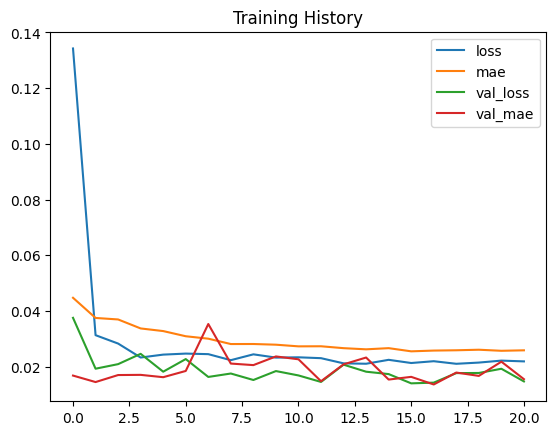

In [41]:
pd.DataFrame(history.history).plot(title="Training History")
plt.show()

# Evaluación

In [42]:
y_pred_scaled = model.predict(X_test_scaled, verbose=0)

In [43]:
y_test_scaled.shape

(106634, 7)

In [44]:
# Back to original units (kW)
y_test_orig = scaler2.inverse_transform(y_test_scaled)
y_pred_orig = scaler2.inverse_transform(y_pred_scaled)

In [45]:
def mape(y_true, y_pred, eps=1e-6):
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def smape(y_true, y_pred, eps=1e-6):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.clip(denom, eps, None)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

In [46]:
yt = y_test_orig.reshape(-1)
yp = y_pred_orig.reshape(-1)

In [47]:
metrics = {}
metrics["MAE"] = float(mean_absolute_error(yt, yp))
metrics["RMSE"] = float(math.sqrt(mean_squared_error(yt, yp)))
metrics["MAPE_%"] = float(mape(yt, yp))
metrics["sMAPE_%"] = float(smape(yt, yp))
metrics["R2"] = float(r2_score(yt, yp))

In [48]:
results_df = pd.DataFrame(metrics, index=["LSTM"]).T
results_df

,LSTM
MAE,4.490316e+03
RMSE,3.400371e+04
MAPE_%,3.061079e+10
sMAPE_%,5.292026e+01
R2,9.843548e-01


In [49]:
print(W, H)

15 7


In [50]:
len(X_train)

319902

In [51]:
sample_idx = 1000 
past = X_test[sample_idx]
truth = y_test_orig[sample_idx]
preds = y_pred_orig[sample_idx]

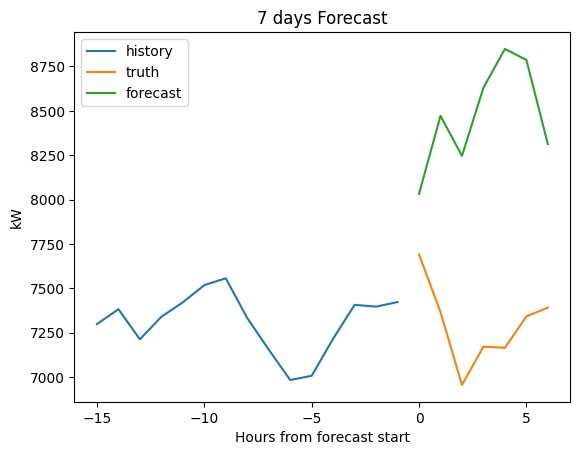

In [53]:
plt.figure()
plt.plot(range(-len(past), 0), past, label="history")
plt.plot(range(0, len(truth)), truth, label="truth")
plt.plot(range(0, len(preds)), preds, label="forecast")
plt.title(f"7 days Forecast")
plt.xlabel("Hours from forecast start")
plt.ylabel("kW")
plt.legend()
plt.show()

In [54]:
sample_idx = 65000 
past = X_test[sample_idx]
truth = y_test_orig[sample_idx]
preds = y_pred_orig[sample_idx]

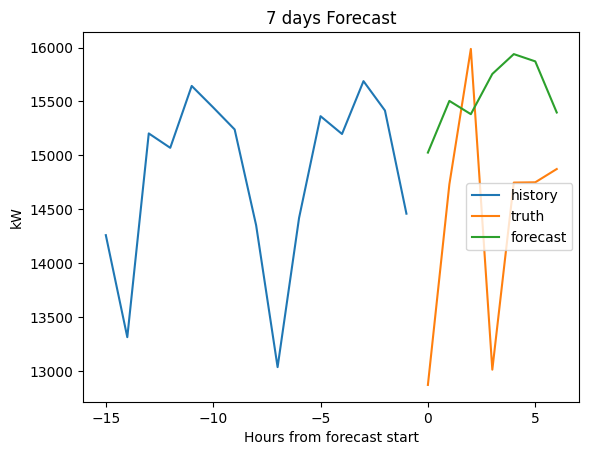

In [55]:
plt.figure()
plt.plot(range(-len(past), 0), past, label="history")
plt.plot(range(0, len(truth)), truth, label="truth")
plt.plot(range(0, len(preds)), preds, label="forecast")
plt.title(f"7 days Forecast")
plt.xlabel("Hours from forecast start")
plt.ylabel("kW")
plt.legend()
plt.show()